# SUSTAV ZA DETEKCIJU KARAKTERISTIČNIH TOČAKA LICA
Toni Polanec 2023.


In [196]:

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns

import random

from tqdm.keras import TqdmCallback
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.initializers import glorot_uniform, he_uniform
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
import pickle


## Analiza podataka

In [197]:
# učitanje slika
face_images = np.load('face_images.npz')
faces=face_images.get(face_images.files[0]) 

# oblikovanje polja
faces=np.moveaxis(faces,-1,0)
faces=faces.reshape(faces.shape[0],faces.shape[1],faces.shape[1],1)

In [198]:
faces.shape

(7049, 96, 96, 1)

Ukupno imamo **7049** različitih slika.  
Svaka slika je veličine **96x96** piksela. 


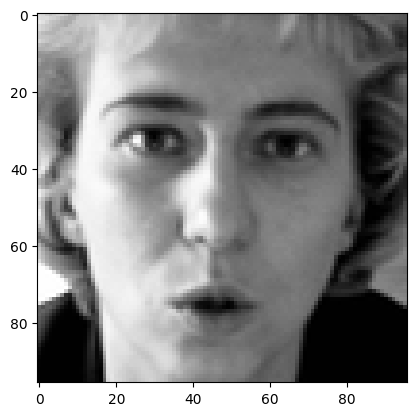

In [199]:
plt.imshow(faces[1], cmap='gray')

^ primjer slike

In [200]:
# čitanje datoteke s karakterističnim točkama lica
landmarks = pd.read_csv('facial_keypoints.csv')
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


Korišteni dataset ima sveukupno 15 karakterističnih točaka lica.  
U ovom radu koristit ćemo samo 9 točaka, i to:
- centar lijevog oka
- lijevi rub lijevog oka
- desni rub desnog oka

- centar desnog oka
- lijevi rub desnog oka
- desni rub desnog oka
  
- vrh nosa
  
- centar gornje usne
- centar donje usne

In [201]:
# brisanje podataka o obrvama i ustima (osim bottom_lip_center)
landmarks = landmarks.drop(['left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y'], axis=1)

In [202]:
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,nose_tip_x,nose_tip_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,44.420571,57.066803,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,48.206298,55.660936,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,47.557263,53.538947,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,51.885078,54.166539,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,43.299534,64.889521,44.962748,73.707387,44.227141,86.871166


In [203]:
landmarks.shape

(7049, 18)

Za svaku sliku imamo 18 parametara koji predstavljaju koordinate 9 različitih točaka na licu (x,y).  
<br>
Zbog nepravilnosti dataseta moramo provjeriti koliko ima nepostojećih vrijednosti.

In [204]:
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64

Vidimo da ih ima dosta pa ćemo to sanirati u sljedećim koracima.

#### Prikaz tablice korelacije između karakterističnih točaka lica:

In [205]:
landmarks_correlation = landmarks.corr()

# plt.figure(figsize=(15,15))
# sns.heatmap(landmarks_correlation, cmap=sns.color_palette("blend:#A5A6B1,#271286", as_cmap=True), annot=True)
# plt.show()


Po grafu iznad vidimo da imamo korelacije između nekih točaka u datasetu. Npr. *right_eye_center_x* i *right_eye_outer_corner_x* imaju korelaciju od 0.86.  
To ćemo iskoristiti da popunimo null vrijednosti u datasetu.  
<br>
Npr. uz pomoć točke centra oka ćemo izračunati točke vanjskog i unutarnjeg ruba oka.



## Predprocesiranje podataka

Po analizi podataka dobili smo informaciju da za karakterističnu točku *eye_center* fali samo 13 vrijednosti. Pa umijesto da izmišljam vrijednosti za te točke, odlučio sam ih izbaciti iz dataseta.



In [206]:
empty_rows = landmarks.isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(how='any')


print("landmarks.shape ->", landmarks.shape)
print("faces.shape ->", faces.shape)
# provjera koliko null vrijednosti imamo u svakom stupcu
#landmarks.isnull().sum()




landmarks.shape -> (2223, 18)
faces.shape -> (2223, 96, 96, 1)


Isto tako za *mouth_center_bottom_lip* fali 33 vrijednosti, pa ćemo i njih izbaciti iz dataseta.


## Afina transformacije

In [207]:
landmarks = np.array(landmarks)
print(landmarks.shape)

(2223, 18)


Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_images: (4446, 96, 96, 1)
Shape of rotated_keypoints:
 (4446, 18)
Shape of images database after shifting: (6669, 96, 96, 1)
Shape of keypoints dataframe after shifting: (6669, 18)


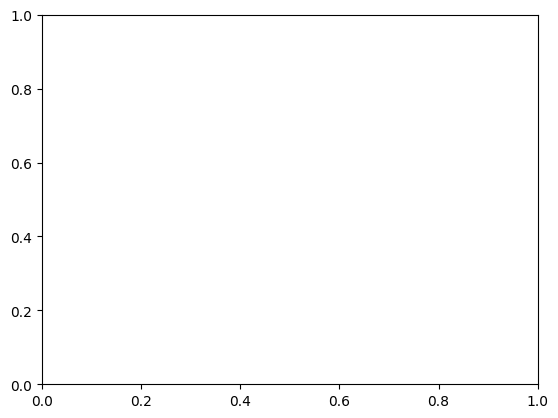

In [208]:
from math import sin, cos, pi
import cv2

sample = 50

rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)

#Function for Rotation of the Images
def rotate(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

#For more details on the transformation of the images below is the link.
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

if True:
    db_images_rotated, df_keypoints_rotated = rotate(faces, landmarks)
    print("\nShape of rotated_images:",np.shape(db_images_rotated))
    print("Shape of rotated_keypoints:\n",np.shape(df_keypoints_rotated))
    
    #Concatenating the train images with rotated image & train keypoints with rotated train points
    faces = np.concatenate((faces, db_images_rotated))
    landmarks = np.concatenate((landmarks, df_keypoints_rotated))
    fig, axis = plt.subplots()
    #plot_image(db_images_rotated[sample], df_keypoints_rotated[sample], axis, "Rotation Augmentation")
    
print("Shape of images database after shifting:",np.shape(faces))
print("Shape of keypoints dataframe after shifting:",np.shape(landmarks))

### Vizualizacija podataka

In [209]:
# https://www.kaggle.com/code/satyaprakash13820/facial-landmark?scriptVersionId=76260280&cellId=13


print(f"faces.shape -> {faces.shape}")
landmark_len = len(landmarks)
print(f"key_feature_num -> {landmark_len}\n")

faces = faces/255 # Normalizacija

#landmarks.reset_index(drop=True, inplace=True)

print(f"normalized_faces.shape -> {faces.shape}")
print(faces)



faces.shape -> (6669, 96, 96, 1)
key_feature_num -> 6669

normalized_faces.shape -> (6669, 96, 96, 1)
[[[[0.93333333]
   [0.9254902 ]
   [0.92941176]
   ...
   [0.98039216]
   [0.98039216]
   [0.98039216]]

  [[0.92156863]
   [0.93333333]
   [0.9254902 ]
   ...
   [0.97647059]
   [0.98039216]
   [0.98431373]]

  [[0.92941176]
   [0.9254902 ]
   [0.92941176]
   ...
   [0.98431373]
   [0.98431373]
   [0.98039216]]

  ...

  [[0.72941176]
   [0.71764706]
   [0.70980392]
   ...
   [0.20392157]
   [0.22352941]
   [0.23529412]]

  [[0.74117647]
   [0.7372549 ]
   [0.81176471]
   ...
   [0.23921569]
   [0.27058824]
   [0.30588235]]

  [[0.74901961]
   [0.72156863]
   [0.72156863]
   ...
   [0.2745098 ]
   [0.29411765]
   [0.35294118]]]


 [[[0.85882353]
   [0.84313725]
   [0.8       ]
   ...
   [0.36078431]
   [0.34509804]
   [0.32941176]]

  [[0.87058824]
   [0.85882353]
   [0.8627451 ]
   ...
   [0.36078431]
   [0.34509804]
   [0.3372549 ]]

  [[0.90588235]
   [0.87843137]
   [0.83137255]
 

In [210]:
def plot_image(image_array, landmarks, index):
    plt.imshow(image_array[index], cmap='gray')
    plt.scatter(landmarks[index][0::2], landmarks[index][1::2], c="#0f0", marker='P')
    # plt.scatter(landmarks.iloc[index,0::2], landmarks.iloc[index,1::2], c="#0f0", marker='P')
    plt.yticks([])
    plt.xticks([])
    print(index)
    plt.show()

4184


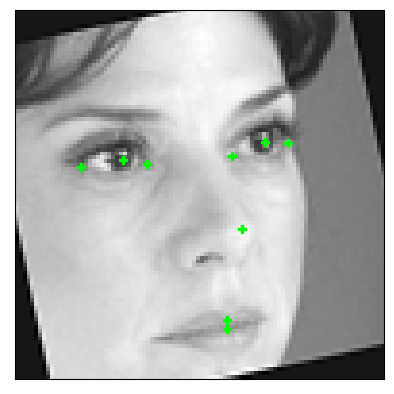

In [211]:
plot_image(faces, landmarks, random.randint(0,6669))

5699


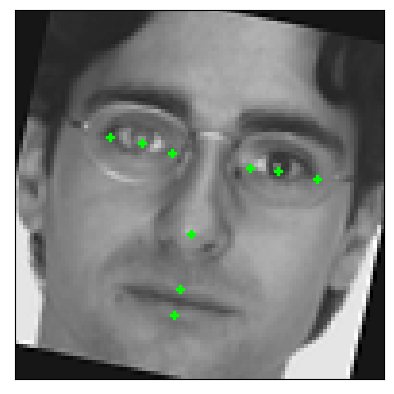

In [212]:
plot_image(faces, landmarks, 5699)

Neke točke nisu najpreciznije označene, ali to je nedostatak izračunavanja nedostajućih vrijednosti u datasetu i sa tim ćemo morati živjeti.

In [213]:
def plot_mult_images(image_array, landmarks, rows = 3, cols = 3):
    default_pics = [random.randint(0,6669) for i in range(rows*cols)]
    pic_size = 96
    index = 0

    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            ax[row,col].imshow(image_array[default_pics[index]], cmap='gray')
            ax[row,col].scatter(landmarks[default_pics[index]][0::2], landmarks[default_pics[index]][1::2], c="#0f0", marker='+')
            # ax[row,col].scatter(landmarks.iloc[default_pics[index],0::2], landmarks.iloc[default_pics[index],1::2], c="#0f0", marker='+')
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(default_pics[index]),fontsize=10)
            index += 1

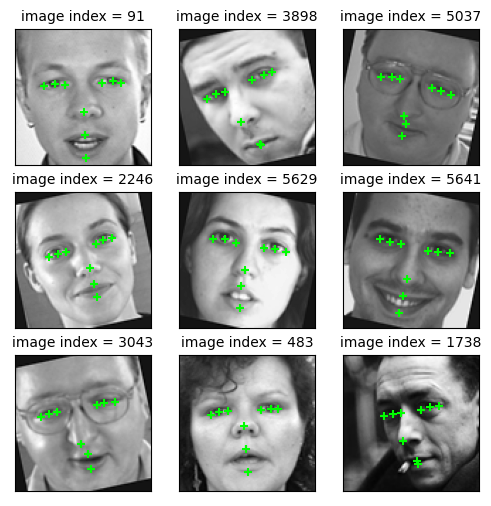

In [214]:
plot_mult_images(faces, landmarks)

## Model

Priprema podataka za treniranje modela.

In [215]:
print(f"faces.shape     -> {faces.shape}")
print(f"landmarks.shape -> {landmarks.shape}")
train_x,test_x,train_y,test_y = train_test_split(faces, landmarks, test_size=0.2, random_state=42)

print(f"\ntrain_x.shape -> {train_x.shape}")
print(f"train_y.shape -> {train_y.shape}")
print(f"test_x.shape  -> {test_x.shape}")
print(f"test_y.shape  -> {test_y.shape}")



faces.shape     -> (6669, 96, 96, 1)
landmarks.shape -> (6669, 18)

train_x.shape -> (5335, 96, 96, 1)
train_y.shape -> (5335, 18)
test_x.shape  -> (1334, 96, 96, 1)
test_y.shape  -> (1334, 18)


In [216]:
img_size=96

model=Sequential()

model.add(Input(shape=(img_size, img_size, 1)))

model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same"))#, kernel_initializer=he_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same"))#, kernel_initializer=he_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))#, kernel_initializer=he_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, kernel_initializer=he_uniform(), activation=LeakyReLU(0.1)))
# model.add(Dense(128, activation=LeakyReLU(0.1)))
model.add(Dropout(0.5))
# # model.add(Dense(64, kernel_initializer=he_uniform(), activation=LeakyReLU(0.1)))
model.add(Dense(64, activation=LeakyReLU(0.1)))
# model.add(LeakyReLU(alpha=0))
model.add(Dense(18))#,kernel_initializer=he_uniform()))


model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=9e-06), metrics=['mean_squared_error'])

In [217]:
model.summary()                      

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  (None, 96, 96, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 96, 96, 32)        320       
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_25 (Bat  (None, 48, 48, 32)      

### Model visualisation

In [218]:
import visualkeras

# visualkeras.layered_view(model, to_file='model_300epochs_128batch_visualisation.png', legend=True).show() # write and show

In [219]:
import graphviz
import pydot

# tf.keras.utils.plot_model(
#     model,
#     to_file="model_300_128_visualisation2.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True)

In [220]:
# from ann_visualizer.visualize import ann_viz

# ann_viz(model, 
#     view=True, 
#     filename="model_300_128_visualisation3.png", 
#     title="Model visualisation")

### Treniranje modela

In [221]:
epochs = 300

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=30, 
    verbose=1,
    restore_best_weights=True)

def learing_rate_changer(epoch, lr):
    if epoch < 0.9*epochs:
        return lr
    else:
        return lr * tf.math.exp(-0.09)    
learning_rate_reduction = tf.keras.callbacks.LearningRateScheduler(learing_rate_changer)

learing_rate_changer_2 = tf.keras.callbacks.ReduceLROnPlateau(mode='auto', factor=0.8, patience=5, verbose=1, min_lr=1e-8)

history = model.fit(
    x = train_x, 
    y = train_y,
    batch_size = 128,
    epochs = epochs,
    validation_data = (test_x, test_y),
    callbacks=[early_stopping, learning_rate_reduction])


model.save('model_temp.h5')
with open('history_temp', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Epoch 1/300
42/42 [==============================] - 46s 1s/step - loss: 2282.2158 - mean_squared_error: 2282.2158 - val_loss: 2537.6731 - val_mean_squared_error: 2537.6731 - lr: 7.0000e-06
Epoch 2/300
42/42 [==============================] - 44s 1s/step - loss: 1661.1284 - mean_squared_error: 1661.1284 - val_loss: 2361.1101 - val_mean_squared_error: 2361.1101 - lr: 7.0000e-06
Epoch 3/300
42/42 [==============================] - 44s 1s/step - loss: 1206.6205 - mean_squared_error: 1206.6205 - val_loss: 2107.1191 - val_mean_squared_error: 2107.1191 - lr: 7.0000e-06
Epoch 4/300
42/42 [==============================] - 45s 1s/step - loss: 885.3835 - mean_squared_error: 885.3835 - val_loss: 1814.2744 - val_mean_squared_error: 1814.2744 - lr: 7.0000e-06
Epoch 5/300
42/42 [==============================] - 44s 1s/step - loss: 676.7825 - mean_squared_error: 676.7825 - val_loss: 1522.1417 - val_mean_squared_error: 1522.1417 - lr: 7.0000e-06
Epoch 6/300
42/42 [==============================] - 4

KeyboardInterrupt: 

In [ ]:
#model.save('model.h5')

---

In [ ]:
# model = load_model('model_300epochs_128batch.h5')
model = load_model('model_300epochs_128batch.h5')
with open('history_60_128_goodgraph', 'rb') as file_pi:
    history = pickle.load(file_pi)

In [ ]:
model.summary()

In [222]:
history = history.history

AttributeError: 'dict' object has no attribute 'history'

---

In [225]:
model.evaluate(test_x, test_y)

42/42 [==============================] - 2s 51ms/step - loss: 86.7265 - mean_squared_error: 86.7265


[86.72653198242188, 86.72653198242188]

Možemo prikazati graf smanjenja greške predikcije kroz epohe.  

Text(0.5, 1.0, 'Loss Curves')

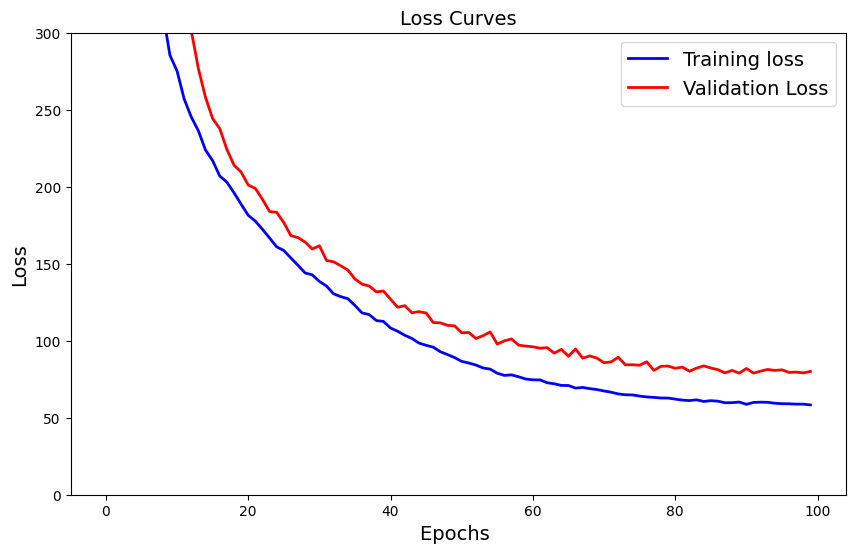

In [223]:

# history_dict = json.load(open('model_history_temp.json', 'r'))


plt.figure(figsize=[10,6])
plt.plot(history['loss'],'b',linewidth=2.0)
plt.plot(history['val_loss'],'r',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=14)
plt.ylim(0, 300)
plt.xlabel('Epochs ',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss Curves',fontsize=14)


In [224]:
y_pred = model.predict(test_x)

42/42 [==============================] - 2s 52ms/step


In [45]:
def plot_predicted_image(images, truth, prediction, index):
    print(index, "->" , prediction[index])
    plt.imshow(images[index], cmap='gray')
    plt.scatter(truth[index][0::2], truth[index][1::2], c="#0f0", marker='P')
    # plt.scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='P')
    plt.scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='P')
    # plt.scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='P')
    plt.legend(["Truth","Prediction"])
    plt.show()

def plot_predicted_images(images, truth, prediction, with_truth=False, random_indexes=True):
    prediction_no_truth = [851, 866, 142, 1241, 1171, 651, 1376, 89, 139]
    prediciton_truth = [73, 501, 277, 189, 644, 268, 679, 864, 452]

    if random_indexes:
        indexes = [random.randint(0, len(test_x))-1 for i in range(9)]
    else:
        if with_truth:
            indexes = prediciton_truth
        else:
            indexes = prediction_no_truth

    rows = 3
    cols = 3

    arr_i = 0
    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            index = indexes[arr_i]
            ax[row,col].imshow(images[index], cmap='gray')
            if with_truth:
                ax[row,col].scatter(truth[index][0::2], truth[index][1::2], c="#0f0", marker='+')
                # ax[row,col].scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='+')
            ax[row,col].scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='+')
            # ax[row,col].set_xticks(())
            # ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(index),fontsize=10)
            arr_i += 1

Usporedimo predicted sliku s originalnom slikom.


In [ ]:
plot_predicted_image(test_x, test_y, y_pred, 10)

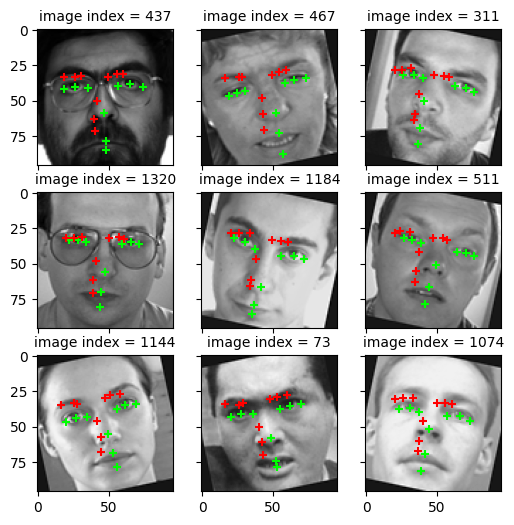

In [229]:
plot_predicted_images(test_x, test_y, y_pred, with_truth=True, random_indexes=True)